In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
%matplotlib inline

import matplotlib.pyplot as plt
from fitting import create_ensemble, get_data, get_datasets

import sys
sys.path.append("../")

folder = ""
save_dir = "alpha_1000_snapshot_2"
all_k, all_images, bins, xx = get_data(folder)


bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)
ensemble = ensemble
ensemble.cuda();

torch.Size([20, 3, 180, 180])
torch.Size([20, 3])
torch.Size([180])


In [2]:
all_k.shape

torch.Size([20, 3])

In [3]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cuda())[0].unsqueeze(0) for i in range(len
                                                                          (ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        torch.save(model_pred, "/".join([save_dir,"model_pred_images.pt"]))
    else:
        model_pred = torch.load( "/".join([save_dir,"model_pred_images.pt"]))


In [4]:
# compare initial beam distributions
from torch_track import Beam

# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]


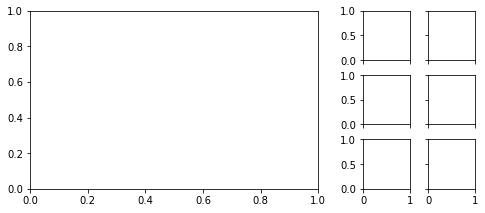

In [5]:
from visualization import add_image, add_projection, add_image_projection
from utils import calc_rms_size
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase


# create gridspec
def create_figure():
    fig = plt.figure()
    fig.set_size_inches(7,3)

    # create subfigures
    subfigs = fig.subfigures(1,2, width_ratios=[5,2],wspace=0.05)
    quad_scan_axis = subfigs[0].subplots(1,gridspec_kw={"right":0.925, "top":0.975, "bottom":0.15})

    proj_axes = subfigs[1].subplots(3,2, sharex="all",sharey="all",gridspec_kw={"hspace":0.3,"wspace":0.4, "top":0.975, "bottom":0.15})
    
    return fig, quad_scan_axis, proj_axes

create_figure();

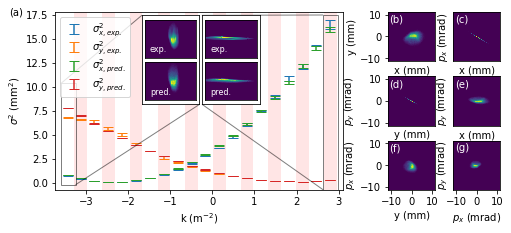

In [6]:
# choose image indexes for comparison
from matplotlib.patches import Rectangle

image_idxs = [0,-1]
image_vmax = None
image_bins = bins
image_linewidth = 1

# choose phase spaces to plot
phase_spaces = [["x","y"],["x","px"],["y","py"],["x","py"],["y","px"],["px","py"]]
phase_space_bins = bins / 1.5

# quad scan
quad_scan_scale = 1e6

# generate plot skeleton
fig, quad_scan_ax, proj_axes = create_figure()

# add quad scan data
means, variances = calc_rms_size(xx, all_images.cpu())
pmeans, pvariances = calc_rms_size(xx, model_pred)

torch.save(variances, "variances.pt")

k = all_k[:, 0].cpu()
mean_variance = torch.mean(variances, dim=-2).cpu() * quad_scan_scale
error_variance = torch.std(variances, dim=-2).cpu() * quad_scan_scale

#quad_scan_ax.plot(k, variances.squeeze()[:,0] * quad_scan_scale,".")
#quad_scan_ax.plot(k, variances.squeeze()[:,1] * quad_scan_scale,".")

quad_scan_ax.errorbar(k, mean_variance[...,0], error_variance[...,0],capsize=5,ls='',
                      label="$\sigma^2_{x, exp.}$")
quad_scan_ax.errorbar(k, mean_variance[...,1], error_variance[...,1],capsize=5,ls='',
                      label="$\sigma^2_{y, exp.}$")

mean_pvariance = torch.mean(pvariances, dim=-2) * quad_scan_scale
error_pvariance = torch.std(pvariances, dim=-2) * quad_scan_scale

quad_scan_ax.errorbar(k, mean_pvariance[...,0], error_pvariance[...,0],capsize=5,
                      ls='', label="$\sigma^2_{x, pred.}$")
quad_scan_ax.errorbar(k, mean_pvariance[...,1], error_pvariance[...,1],capsize=5,
                      ls='', label="$\sigma^2_{y, pred.}$")

# denote training and testing data
rw = 0.3
y0,y1 = quad_scan_ax.get_ylim()
for ele in k[1::2]:
    rect = Rectangle((ele - rw/2, y0), rw, y1-y0, facecolor="red",alpha=0.1,zorder=0)
    quad_scan_ax.add_patch(rect)

quad_scan_ax.set_xlabel("k (m$^{-2}$)")
quad_scan_ax.set_ylabel("$\sigma^2$ (mm$^2$)")
quad_scan_ax.legend(loc=2,labelspacing=0.1)

def remove_ticks(ax):
    ax.set_yticks([])
    ax.set_xticks([])
    
# add inset axes for images
indicator_width = 0.35
indicator_buffer = 1.0
inset_height = 0.5
gap = 0.05
image_extent = 10

inset_locs = torch.tensor([0.25, 0.46]) + 0.05

for j, idx in enumerate(image_idxs[:2]):
    center_k = k[idx]

    axins = quad_scan_ax.inset_axes([inset_locs[j],1 - inset_height - 0.02,inset_height*0.4,inset_height])
    quad_scan_ax.indicate_inset(
        [
            center_k - indicator_width/2, 
            torch.min(mean_pvariance[idx]) - indicator_buffer, 
            indicator_width, 
            torch.max(mean_pvariance[idx]) + 2*indicator_buffer + torch.min(mean_pvariance[idx])
        ], 
        inset_ax=axins, edgecolor="black"
    )
    remove_ticks(axins)
    
    top_ax = axins.inset_axes([gap, 0.5+gap/2, 1-2*gap,0.5 - 1.5*gap])
    remove_ticks(top_ax)

    bottom_ax = axins.inset_axes([gap,gap,1-2*gap,0.5 - 1.5*gap])
    remove_ticks(bottom_ax)
    
    top_ax.pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0].cpu(),vmax=image_vmax)
    bottom_ax.pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0].cpu(),vmax=image_vmax)
    
    for a, txt in zip((top_ax, bottom_ax),("exp.","pred.")):
        a.text(0.1, 0.1,txt, ha='left',
                   va='bottom', transform=a.transAxes,
                   fontdict={'size': 8}, c="white")
    
    for ele in [top_ax, bottom_ax]:
        ele.set_ylim(-image_extent, image_extent)
        ele.set_xlim(-image_extent, image_extent)
        ele.collections[0].set_rasterized(True)


# get list of axes for plotting the phase space projections
ph_axes = proj_axes.flatten()

# add phase space projections
for ax, pair in zip(ph_axes, phase_spaces):
    _, pred_image = add_image(ax, *pair, pred_initial_beams, [phase_space_bins]*2,
                              scale_axis=1e3)
    ax.collections[0].set_rasterized(True)
    unit = []
    for i in [0,1]:
        if "p" in pair[i]:
            pair[i] = f"$p_{pair[i][-1]}$"
            unit += ["(mrad)"]
        else:
            unit += ["(mm)"]

    ax.set_xlabel(pair[0] + " " + unit[0])
    ax.set_ylabel(pair[1] + " " + unit[1], labelpad=3)
    
for a in proj_axes[:2, :2].flatten():
    a.tick_params(axis='x', which='both',length=0)
    
for a in proj_axes[:,1:].flatten():
    a.tick_params(axis='y', which='both',length=0)

# add lettering
letters = "abcdefg"
quad_scan_ax.text(-0.135, 1.0, f"({letters[0]})", ha='center',
                   va='center', transform=quad_scan_ax.transAxes)

for a, l in zip(ph_axes.flatten(), letters[1:]):
    a.text(0.025, 0.95, f"({l})", ha='left',
                   va='top', transform=a.transAxes,
                   c="white")

#ph_axes.flatten()[-1].set_ylabel("$\delta$ (10$^{-3}$)");
fig.savefig("exp_results.png", dpi=300)
fig.savefig("exp_results.svg")
    

In [7]:
# do quad scan analysis
import sys
sys.path.append("../")

from quad_scan_emittance_fit import ReparameterizedEmittanceQuadScan
from torch.nn.functional import mse_loss

mean_energy = 65
gamma = mean_energy / 0.511
norm_scale = 1e6

model = ReparameterizedEmittanceQuadScan(torch.tensor(2.84 + 0.54), torch.tensor(0.12))
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=0.0001)

idx = slice(10,20,1)

for i in range(5000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(all_k.cpu()[idx])
    # Calc loss and backprop gradients
    loss = mse_loss(output*norm_scale, variances[...,1].cpu()[idx]*norm_scale)
    loss.backward()
    #print(loss)
    optimizer.step()

for i in range(10000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(all_k.cpu())
    # Calc loss and backprop gradients
    loss = mse_loss(output*norm_scale, variances[...,0].cpu()*norm_scale)
    loss.backward()
    if not i % 1000:
        print(loss)
    optimizer.step()
    
print(model.emittance.sqrt()*gamma)
print(list(model.named_parameters()))

gauss_x_var = model(k)

model = ReparameterizedEmittanceQuadScan(torch.tensor(2.84 + 0.54), torch.tensor(0.12))
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=0.0001)
idx = slice(0,10,1)

for i in range(10000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(all_k.cpu()[idx])
    # Calc loss and backprop gradients
    loss = mse_loss(output*norm_scale, variances[...,1].cpu()[idx]*norm_scale)
    loss.backward()
    #print(loss)
    optimizer.step()

for i in range(20000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(all_k.cpu())
    # Calc loss and backprop gradients
    loss = mse_loss(output*norm_scale, variances[...,1].cpu()*norm_scale)
    loss.backward()
    if not i % 1000:
        print(loss)
    optimizer.step()

gauss_y_var = model(k)
print(model.emittance.sqrt()*gamma)
print(list(model.named_parameters()))


tensor(44.3319, grad_fn=<MseLossBackward0>)
tensor(0.0618, grad_fn=<MseLossBackward0>)
tensor(0.0618, grad_fn=<MseLossBackward0>)
tensor(0.0618, grad_fn=<MseLossBackward0>)
tensor(0.0618, grad_fn=<MseLossBackward0>)
tensor(0.0618, grad_fn=<MseLossBackward0>)
tensor(0.0617, grad_fn=<MseLossBackward0>)
tensor(0.0610, grad_fn=<MseLossBackward0>)
tensor(0.0536, grad_fn=<MseLossBackward0>)
tensor(0.0440, grad_fn=<MseLossBackward0>)
tensor(2.0579e-05, grad_fn=<MulBackward0>)
[('raw_c', Parameter containing:
tensor([-0.3356], requires_grad=True)), ('lambda_', Parameter containing:
tensor([1.9275e-03, 8.8718e-05], requires_grad=True))]
tensor(6.6240, grad_fn=<MseLossBackward0>)
tensor(1.3171, grad_fn=<MseLossBackward0>)
tensor(0.8496, grad_fn=<MseLossBackward0>)
tensor(0.5349, grad_fn=<MseLossBackward0>)
tensor(0.3254, grad_fn=<MseLossBackward0>)
tensor(0.1949, grad_fn=<MseLossBackward0>)
tensor(0.1218, grad_fn=<MseLossBackward0>)
tensor(0.0866, grad_fn=<MseLossBackward0>)
tensor(0.0728, grad_

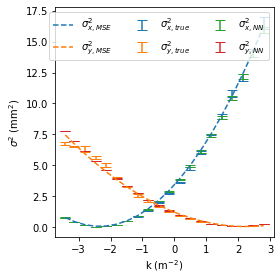

In [8]:
fig,ax = plt.subplots()
fig.set_size_inches(4,4)
scale_factor = 1
plot_mean_variance = mean_variance*scale_factor
plot_mean_pvariance = mean_pvariance * scale_factor
plot_error_pvariance = error_pvariance * scale_factor
plot_error_variance = error_variance * scale_factor
plot_gauss_x_var = gauss_x_var*scale_factor*1e6
plot_gauss_y_var = gauss_y_var*scale_factor*1e6

ax.errorbar(k, 
             plot_mean_variance[...,0],
             plot_error_variance[...,0], 
             ls="",capsize=5,label="$\sigma_{x, true}^2$")
ax.errorbar(k, 
             plot_mean_variance[...,1],
             plot_error_variance[...,1],
             ls="",capsize=5,label="$\sigma_{y, true}^2$")


ax.errorbar(k,
            plot_mean_pvariance[...,0],
            plot_error_pvariance[...,0],
            capsize=5,ls='', label="$\sigma_{x, NN}^2$")
ax.errorbar(k,
            plot_mean_pvariance[...,1],
            plot_error_pvariance[...,1],
            capsize=5,ls='', label="$\sigma_{y, NN}^2$"
            )

# print gaussian approx pred
ax.plot(k, plot_gauss_x_var.detach(),"--C0", label="$\sigma_{x, MSE}^2$")
ax.plot(k, plot_gauss_y_var.detach(),"--C1", label="$\sigma_{y, MSE}^2$")

ax.set_ylabel("$\sigma^2$ (mm$^2$)")
ax.set_xlabel("k (m$^{-2}$)")
ax.legend(ncol=3)
fig.tight_layout()

In [9]:
def get_cov(beam):
    beam_data = beam.data
    #beam_data[:,1] = beam.xp
    #beam_data[:,3] = beam.yp

    return torch.cov(beam_data.T)


pred_emit = torch.tensor(
    [get_cov(ele)[0:2,0:2].det().sqrt() for ele in pred_initial_beams]
)
print("x")
print(pred_emit.mean()*gamma)
print(pred_emit.std()*gamma)

pred_emit = torch.tensor(
    [get_cov(ele)[2:4,2:4].det().sqrt() for ele in pred_initial_beams]
)
print("y")
print(pred_emit.mean()*gamma)
print(pred_emit.std()*gamma)




x
tensor(1.4943e-05)
tensor(3.0377e-07)
y
tensor(1.3963e-05)
tensor(8.2462e-08)


In [10]:
import matplotlib
matplotlib.matplotlib_fname()

'C:\\ProgramData\\Miniconda3\\envs\\phase_space_reconstruction\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc'